In [1]:
#multi channel CNN for sentiment analysis
from nltk.corpus import stopwords
from string import punctuation
import pandas as pd
import numpy as np
import re
import json
# import codecs
import word2vecReader as godin_embedding
from keras.utils import to_categorical
from keras.models import load_model
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [5,5]
plt.style.use('seaborn-notebook')
from sklearn.metrics import mean_squared_error,r2_score,confusion_matrix
from aspect_specific_prob import get_normalized_sentence_relation_vector
from scipy.interpolate import interp1d
import itertools

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
#loading data
def load_data_from_file(filename):
    print("loading file = ",filename)
    with open(filename,'r') as f:
        foo = json.load(f)
        
    sentence_id =[]
    sentence = []
    score = []
    for key in foo.keys():
        for info in foo[key]['info']:
#             print(eval(info['snippets'])[0])
            sentence.append(eval(info['snippets'])[0])
            score.append(float(info['sentiment_score']))
#         sentence_id.append(key)
#         sentence.append(foo[key]['sentence'])
#         score.append(float(foo[key]['info'][0]['sentiment_score']))
    labels = [1 if x>=0 else 0 for x in score]
    return sentence_id,sentence,score,labels

In [3]:
# def load_data_temp(filename):
#     print("loading file = ",filename)
#     with open(filename,'r') as f:
#         foo = json.load(f)
#     return foo['sentence'],foo['labels']

In [4]:
sentence_id,dataX,score,dataY = load_data_from_file('dataset/master.json')
# dataX,dataY = load_data_temp('dataset/final_dev.json')

loading file =  dataset/master.json


In [5]:
print('data len')
print(len(dataX),len(dataY))

data len
1171 1171


In [6]:
print('count 1,count 0')
print(dataY.count(1),dataY.count(0))

count 1,count 0
772 399


In [7]:
def remove_punctuation(s):
    list_punctuation = list(punctuation.replace('$',''))
    for i in list_punctuation:
        s = s.replace(i,'')
    return s

In [8]:
def clean_sentence(sentence):
    #remove multiple repeat non num-aplha char !!!!!!!!!-->!
    sentence = re.sub(r'(\W)\1{2,}', r'\1', sentence) 
    #removes alpha char repeating more than twice aaaa->aa
    sentence = re.sub(r'(\w)\1{2,}', r'\1\1', sentence)
    #removes links
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', r'', sentence)
    # remove @usernames
    sentence = re.sub(r"\@(\w+)", "", sentence)
    #removing stock names to see if it helps
#     sentence = re.sub(r"(?:\$|https?\://)\S+", "", sentence)
    #remove # from #tags
    sentence = sentence.replace('#','')
    # split into tokens by white space
    tokens = sentence.split()
    # remove punctuation from each token
    tokens = [remove_punctuation(w) for w in tokens]
#     remove remaining tokens that are not alphabetic
#     tokens = [word for word in tokens if word.isalpha()]
#no removing non alpha words to keep stock names($ZSL)
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)
    return tokens

In [9]:
print('cleaning train set')
dataX = [clean_sentence(x) for x in dataX]

cleaning train set


In [10]:
dataY = to_categorical(dataY,2)

In [11]:
max_length = 27

In [12]:
len(dataY)

1171

In [13]:
len(dataX)

1171

In [14]:
# def progress_print(s):
#     global count
#     count+=1
#     if count%10==0:
#         print(count)
#     return get_normalized_sentence_relation_vector(s)

In [15]:
# count = 0
# sentence_enchance_prob = [progress_print(x) for x in dataX]

In [16]:
# sentence_enchance_prob_f = [x[0] for x in sentence_enchance_prob]

In [17]:
# sentence_enchance_prob_f

In [18]:
# max_length

In [19]:
def load_google_word2vec(file_name):
    print("Loading word2vec model, this can take some time...")
    return KeyedVectors.load_word2vec_format(file_name, binary=True)

In [20]:
#loading godin word embedding
def load_godin_word_embedding(path):
    print("Loading goding model, this can take some time...")
    return godin_embedding.Word2Vec.load_word2vec_format(path, binary=True)

In [21]:
word2vec_model= load_google_word2vec('word_embeddings/GoogleNews-vectors-negative300.bin')

Loading word2vec model, this can take some time...


In [22]:
godin_model = load_godin_word_embedding("word_embeddings/word2vec_twitter_model.bin")

Loading goding model, this can take some time...


In [23]:
def get_embedding_matrix(model,sentence,godin_flag = False):
    tokens = sentence.split()[:max_length]
    if godin_flag:
        embedding_matrix = np.zeros((max_length,400))
    else:
        embedding_matrix = np.zeros((max_length,300))
    for i,word in enumerate(tokens):
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
#             embedding_matrix[i]*=prob_vector[i]
    return embedding_matrix

In [24]:
# print("bulding word2vec matrix of train set")
# train_word2vec = np.asarray([get_embedding_matrix(word2vec_model,x,y) for x,y in zip(dataX,sentence_enchance_prob_f)])
# print("bulding godin matrix of train set")
# train_godin = np.asarray([get_embedding_matrix(godin_model,x,y,godin_flag=True) for x,y in zip(dataX,sentence_enchance_prob_f)])

In [25]:
print("bulding word2vec matrix of train set")
train_word2vec = np.asarray([get_embedding_matrix(word2vec_model,x) for x in dataX])
print("bulding godin matrix of train set")
train_godin = np.asarray([get_embedding_matrix(godin_model,x,godin_flag=True) for x in dataX])

bulding word2vec matrix of train set
bulding godin matrix of train set


In [26]:
input_array = [train_godin,train_word2vec,train_godin]

In [315]:
model = load_model('models/bestSenti.h5')

In [316]:
pred = model.predict(input_array)

In [317]:
def get_acc(pred,dataY):
    pred_class = np.asarray([np.asarray([1,0],dtype=np.float32) if x[0]>x[1] else np.asarray([0,1],dtype=np.float32) for x in pred])
    count = [True if x[0]==y[0] else False for x,y in zip(pred_class,dataY)]
    return float(count.count(True))/len(count)

In [318]:
get_acc(pred,dataY)

0.8061485909479078

In [319]:
def plot_confusion_matrix(pred,dataY):
    classes = ['Negative','Positive']
    pred_class = [0 if x[0]>x[1] else 1 for x in pred]
    acc_class = [0 if x[0]>x[1] else 1 for x in dataY]
    count = 0
    cm = confusion_matrix(acc_class,pred_class)
    plt.imshow(cm)
    plt.colorbar()
    plt.xticks(np.arange(len(classes)),classes,fontsize=14)
    plt.yticks(np.arange(len(classes)),classes,fontsize=14)
    plt.ylabel('True label',fontsize=14)
    plt.xlabel('Predicted label',fontsize=14)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i,format(cm[i, j], fmt),
                 horizontalalignment="center",fontsize=14,
                 color="white" if cm[i, j] > thresh else "black")

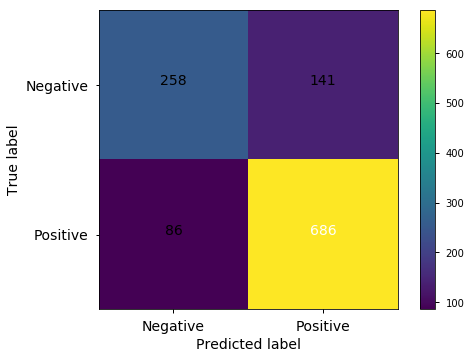

In [320]:
plot_confusion_matrix(pred,dataY)

In [359]:
# def mean_normalize(series,c_value):
#     mean_series = np.mean(series)
#     std_series = np.std(series)
#     return [((x-mean_series)/std_series)+c_value for x in series]

In [360]:
# def rescale(series,new_range):
#     m = interp1d([min(series),max(series)],new_range)
#     return [float(m(x)) for x in series]

In [361]:
# def normalizing_score(score_pred,v1,v2):
#     index_of_positive = [i for i,x in enumerate(score_pred) if x>=0]
#     index_of_negative = [i for i,x in enumerate(score_pred) if x<0]
    
#     positive_score = np.asarray([score_pred[x] for x in index_of_positive])
#     p_mean = np.mean(positive_score)
#     p_std = np.std(positive_score)
    
#     negative_score = np.asarray([score_pred[x] for x in index_of_negative])
#     n_mean = np.mean(negative_score)
#     n_std = np.std(negative_score)
    
#     positive_score = [((x-p_mean)/p_std)+v1 for x in positive_score]
#     negative_score = [((x-n_mean)/n_std)+v1 for x in negative_score]
    
#     positive_score = rescale(positive_score,[0,1])
#     negative_score = rescale(negative_score,[-1,0])
    
#     for p,i in zip(positive_score,index_of_positive):
#         score_pred[i] = p
#     for n,i in zip(negative_score,index_of_negative):
#         score_pred[i] = n
    
#     return score_pred

In [362]:
def get_score_from_pred(pred):
    score_pred = []
    for x in pred:
        p_s = x[1]
        n_s = x[0]
        score_pred.append(p_s-n_s)
    return score_pred

In [363]:
def get_MSE_and_R2_search(pred,score,v1,v2):
    score_pred = get_score_from_pred(pred)
    mse = mean_squared_error(score,score_pred)
    r2 = r2_score(score,score_pred)
    return mse,r2,score_pred

In [364]:
mse,r2,score_pred = get_MSE_and_R2_search(pred,score,0.2,-0.5)

In [365]:
mse,r2

(0.3169242436630847, -0.990733449102535)

(array([ 71.,  78.,  80.,  53.,  65.,  72.,  76.,  82., 108., 486.]),
 array([-0.99114752, -0.79203279, -0.59291806, -0.39380333, -0.19468861,
         0.00442612,  0.20354085,  0.40265558,  0.60177031,  0.80088503,
         0.99999976]),
 <a list of 10 Patch objects>)

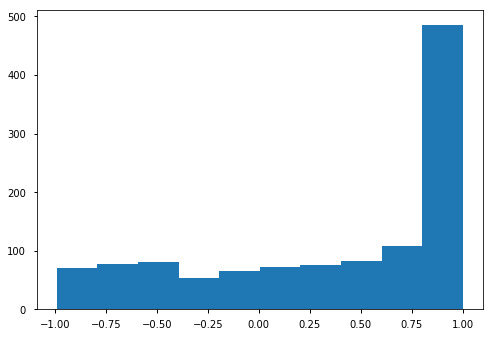

In [366]:
plt.hist(score_pred)

(array([  8.,  52., 147., 129.,  86., 121., 272., 269.,  77.,  10.]),
 array([-0.938 , -0.7467, -0.5554, -0.3641, -0.1728,  0.0185,  0.2098,
         0.4011,  0.5924,  0.7837,  0.975 ]),
 <a list of 10 Patch objects>)

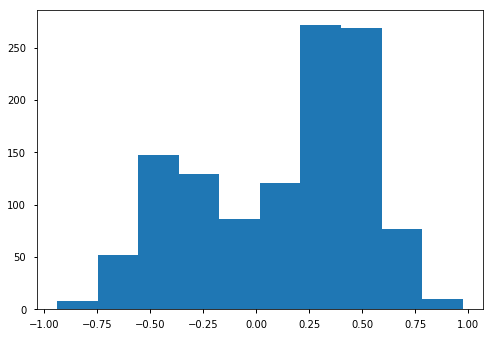

In [340]:
plt.hist(score)

In [20]:
# with open('top20models/emb_key.json') as f:
#     top_models = json.load(f)

In [21]:
# def get_prediction_of_top_n_model(n):
#     pred_n = []
#     for x in range(1,n+1):
#         print('predicting for model rank',x)
#         model_name = top_models[str(x)]['key']
#         model_embeddings = top_models[str(x)]['embeddings']
#         input_array = [train_word2vec if x=='embedding_matrix_word2vec' else train_godin for x in model_embeddings]
#         model = load_model('top20models/'+str(model_name)+'.h5')
#         pred_n.append(model.predict(input_array))
#         del model
#     return pred_n

In [35]:
# def get_ensemble_pred(pred_n):
#     pred = []
#     n_of_pred = len(pred_n)
#     n_of_sampels = len(pred_n[0])
#     for x in range(n_of_sampels):
#         sum_0 = 0.0
#         sum_1 = 0.0
#         for v in pred_n:
#             sum_0+=v[x][0]
#             sum_1+=v[x][1]
#         pred.append(np.asarray([sum_0/n_of_pred,sum_1/n_of_pred],dtype=np.float32))
#     return np.asarray(pred,dtype=np.float32)

In [233]:
# pred_n = get_prediction_of_top_n_model(3)

In [234]:
# pred = get_ensemble_pred(pred_n)

In [235]:
# get_acc(pred,dataY)

In [37]:
# no_of_top_models = []
# acc_score = []
# n_of_top_model_to_use = 20
# pred_n = get_prediction_of_top_n_model(n_of_top_model_to_use)
# print("now doing ensemble")
# for i in range(1,n_of_top_model_to_use+1):
#     no_of_top_models.append(i)
#     pred = get_ensemble_pred(pred_n[:i])
#     acc_score.append(get_acc(pred,dataY))

In [38]:
# no_of_top_models

In [39]:
# acc_score

In [40]:
# plt.plot(no_of_top_models, acc_score)
# plt.xlabel('Number of models in ensemble')
# plt.ylabel('accuracy')

In [133]:
# model_name = top_models[str(1)]['key']
# model_name

In [134]:
# model_embeddings = top_models[str(1)]['embeddings']
# model_embeddings

In [135]:
# input_array = [train_word2vec if x=='embedding_matrix_word2vec' else train_godin for x in model_embeddings]

In [136]:
# model = load_model('top20models/'+str(model_name)+'.h5')

In [137]:
# pred = model.predict(input_array)

In [139]:
# get_acc(pred,dataY)